Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:
1) добавьте лемматизацию в предобработку (любым способом)
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

from tqdm.auto import tqdm
from pymystem3 import Mystem
mystem = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
wiki = open('/content/drive/MyDrive/wiki_data.txt', 'r', encoding='utf-8').read().split('\n')

In [4]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [5]:
pip install pymorphy3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 80.5 MB/s eta 0:00:00


Добавил лемматизацию через pymorphy3

In [6]:
from pymorphy3 import MorphAnalyzer
import re
def preprocess(text):
    morph = MorphAnalyzer()
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    tokens = [morph.parse(token)[0].normal_form for token in tokens]
    return tokens

In [7]:
vocab = Counter()

for text in tqdm(wiki):
    vocab.update(preprocess(text))


  0%|          | 0/20003 [00:00<?, ?it/s]

In [8]:
vocab.most_common(10)

[('в', 275172),
 ('и', 146585),
 ('год', 94984),
 ('на', 81230),
 ('—', 67491),
 ('с', 65101),
 ('быть', 58292),
 ('он', 38697),
 ('по', 36506),
 ('из', 26665)]

In [9]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

len(filtered_vocab)

12460

In [10]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [11]:
id2word = {i:word for word, i in word2id.items()}

In [12]:
sentences = []

for text in tqdm(wiki):
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

  0%|          | 0/20003 [00:00<?, ?it/s]

Изменил окно в большую сторону

In [13]:
vocab_size = len(id2word)

In [14]:
# skip gram
def gen_batches_sg(sentences, window = 7, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []


In [15]:
# # cbow
def gen_batches_cbow(sentences, window = 7, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

Размер итогового вектора установил 200

In [16]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_1 = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])




In [17]:
model_1.fit(gen_batches_sg(sentences[:19000], window=7),
          validation_data=gen_batches_sg(sentences[19000:],  window=7),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
10000/10000 [==============================] - 89s 9ms/step - loss: 0.4394 - accuracy: 0.8057 - val_loss: 0.4742 - val_accuracy: 0.8008
Epoch 2/2
10000/10000 [==============================] - 71s 7ms/step - loss: 0.4053 - accuracy: 0.8249 - val_loss: 0.4101 - val_accuracy: 0.8240


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


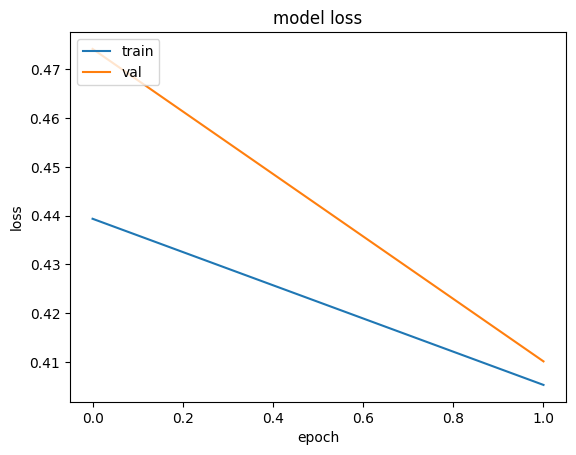

In [18]:
print(model_1.history.history.keys())
# summarize history for accuracy
plt.plot(model_1.history.history['loss'])
plt.plot(model_1.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
embeddings = model_1.layers[2].get_weights()[0]

In [20]:
embeddings[0]

array([ 0.03612179, -0.00800356, -0.01793056, -0.01818651, -0.02158554,
        0.04772821, -0.01293678, -0.00428528,  0.04138586,  0.03820044,
       -0.04025376, -0.01220987,  0.00461769,  0.00244509,  0.01704263,
       -0.0391467 ,  0.00478657, -0.04015514,  0.04136806,  0.00897982,
       -0.04256188, -0.04775557,  0.03624655,  0.02432204, -0.01845293,
       -0.00738419,  0.00871778, -0.0058583 ,  0.0249101 ,  0.00330309,
       -0.04313456,  0.02200732,  0.01664252,  0.03985126,  0.04275891,
        0.03593011,  0.0257482 , -0.04571025, -0.0167791 , -0.00531044,
       -0.04323728,  0.03233496,  0.04906387,  0.04572633, -0.00665673,
       -0.04317892, -0.0230144 , -0.04460243, -0.000415  , -0.02878227,
       -0.02432775,  0.0373941 , -0.01535435,  0.01018083, -0.00696099,
        0.04015018, -0.03027339,  0.04031748,  0.04042381, -0.04942995,
       -0.03698749, -0.02345373, -0.0165992 ,  0.00967631, -0.01675788,
       -0.04945279, -0.00966744, -0.04578979, -0.00569129,  0.00

In [21]:
most_similar('церковь', embeddings)

['церковь',
 'храм',
 'монастырь',
 'православный',
 'святой',
 'собор',
 'святитель',
 'лик',
 'епархия',
 'придел']

In [22]:
most_similar('кран', embeddings)

['кран',
 'пучок',
 'жёсткость',
 'пакет',
 'чётко',
 'слепой',
 'поставлять',
 'почувствовать',
 'рана',
 'ракета']

In [23]:
most_similar('офис', embeddings)

['офис',
 'тематический',
 'брехт',
 'газетный',
 'узловой',
 'тайский',
 'доходный',
 'пародия',
 'вымирание',
 'царскосельский']

In [24]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_2 = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [25]:
model_2.fit(gen_batches_cbow(sentences[:19000], window=7),
          validation_data=gen_batches_cbow(sentences[19000:],  window=7),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 127s 25ms/step - loss: 0.3714 - accuracy: 0.8400 - val_loss: 0.3143 - val_accuracy: 0.8720
Epoch 2/2
5000/5000 [==============================] - 60s 12ms/step - loss: 0.2817 - accuracy: 0.8842 - val_loss: 0.2614 - val_accuracy: 0.8945


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


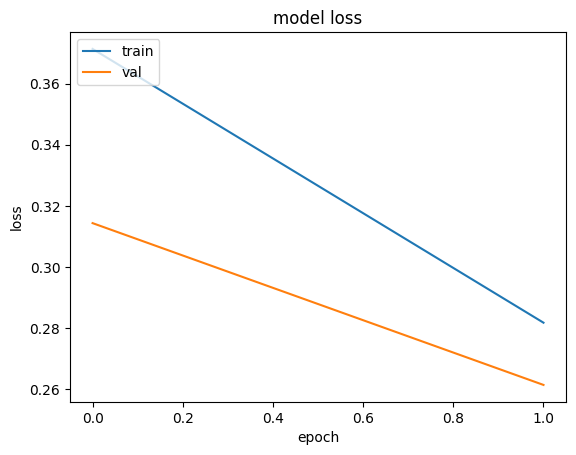

In [26]:
print(model_2.history.history.keys())
# summarize history for accuracy
plt.plot(model_2.history.history['loss'])
plt.plot(model_2.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
embeddings = model_2.layers[2].get_weights()[0]

In [28]:
most_similar('церковь', embeddings)

['церковь',
 'храм',
 'монастырь',
 'собор',
 'святой',
 'икона',
 'епископ',
 'православный',
 'построить',
 'приход']

In [29]:
most_similar('кран', embeddings)

['кран',
 'плитка',
 'крючок',
 'бизоновый',
 'накопитель',
 'рукоятка',
 'имплантат',
 'наклонный',
 'дисплей',
 'радар']

In [30]:
most_similar('офис', embeddings)

['офис',
 'отель',
 'оттава',
 'кафе',
 'гараж',
 'сан-франциско',
 'ижевск',
 'коммунальный',
 'казино',
 'штаб-квартира']

---------------

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [31]:
!pip install gensim

In [32]:
import gensim

In [35]:
wiki = open('/content/drive/MyDrive/wiki_data.txt', 'r', encoding='utf-8').read().split('\n')

In [36]:
texts = [preprocess(text) for text in wiki]

In [37]:
w2v = gensim.models.Word2Vec(texts,
                             hs=0,
                             negative=10,
                             sample=1e-4,
                             vector_size=200,
                             min_count=5,
                             max_vocab_size=10000,
                             window=7,
                             epochs=10)

In [38]:
w2v.wv.most_similar('церковь')

[('храм', 0.8019300103187561),
 ('часовня', 0.8016335964202881),
 ('богородица', 0.7669553160667419),
 ('святитель', 0.7419413924217224),
 ('православный', 0.7333118915557861),
 ('собор', 0.7066504955291748),
 ('церковный', 0.7032696604728699),
 ('монастырь', 0.6722450256347656),
 ('приход', 0.6720608472824097),
 ('возвести', 0.6429876685142517)]

In [39]:
w2v.wv.most_similar('автомобиль')

[('шасси', 0.7531746625900269),
 ('кузов', 0.7440350651741028),
 ('двигатель', 0.6990637183189392),
 ('колесо', 0.6920391917228699),
 ('машина', 0.6894317865371704),
 ('модель', 0.6772661209106445),
 ('шина', 0.6715955138206482),
 ('подвеска', 0.6382321715354919),
 ('benetton', 0.6001132726669312),
 ('модификация', 0.5900213718414307)]

In [40]:
ft = gensim.models.FastText(texts, min_n=4, max_n=10, window=10, epochs=10)

In [41]:
ft.wv.most_similar('церковь')

[('«церковь', 0.9932422637939453),
 ('церковь»', 0.9929953217506409),
 ('це́рковь', 0.9312790036201477),
 ('церква', 0.9155018925666809),
 ('церкви»', 0.885475218296051),
 ('морковь', 0.817210853099823),
 ('храм', 0.7884982228279114),
 ('«храм', 0.7794929146766663),
 ('церковный', 0.7637929916381836),
 ('архипастырь', 0.7619302868843079)]

In [42]:
ft.wv.most_similar('автомобиль')

[('спецавтомобиль', 0.9821977019309998),
 ('локомобиль', 0.9293738603591919),
 ('бронеавтомобиль', 0.9035617113113403),
 ('автомобилист', 0.8762359619140625),
 ('автомотриса', 0.8600661158561707),
 ('нобиль', 0.8170742988586426),
 ('автомобильный', 0.780545175075531),
 ('«автомобилист»', 0.7789194583892822),
 ('автомобилестроение', 0.772947371006012),
 ('биль', 0.7399547696113586)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019).
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

*__Там где сейчас плоские графики у меня еще получалось чтобы где-то посередине был резкий скачок вверх и обратно вниз, и дальше опять ровно.__*


In [43]:
data = pd.read_csv('/content/drive/MyDrive/labeled.csv')

In [44]:
data['norm_text'] = data.comment.apply(preprocess)

In [45]:
vocab1 = Counter()

for text in data['norm_text']:
    vocab1.update(text)

filtered_vocab1 = set()

for word in vocab:
    if vocab1[word] > 5:
        filtered_vocab1.add(word)

len(filtered_vocab1)

5792

In [46]:
word2id1 = { 'PAD':0}

for word in filtered_vocab1:
    word2id1[word] = len(word2id1)
id2word1 = {i:word for word, i in word2id1.items()}

In [47]:
X = []

for tokens in data['norm_text']:
    ids = [word2id1[token] for token in tokens if token in word2id1]
    X.append(ids)

In [48]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [50]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
# embedding слой возвращает последовательность векторов
# а нам нужно классифицировать сразу весь текст
# стандартный подход в этом случае - усреднить единичные вектора в 1 вектор текста
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
# к усредненному вектору мы уже применяем полносвязный слой, который вернет вероятность токсичности
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [51]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=10)

Epoch 1/10
428/428 [==============================] - 35s 78ms/step - loss: 0.6152 - accuracy: 0.6648 - val_loss: 0.5742 - val_accuracy: 0.6602
Epoch 2/10
428/428 [==============================] - 9s 21ms/step - loss: 0.5279 - accuracy: 0.7142 - val_loss: 0.4911 - val_accuracy: 0.8350
Epoch 3/10
428/428 [==============================] - 4s 10ms/step - loss: 0.4359 - accuracy: 0.8172 - val_loss: 0.4290 - val_accuracy: 0.8197
Epoch 4/10
428/428 [==============================] - 4s 9ms/step - loss: 0.3720 - accuracy: 0.8576 - val_loss: 0.4016 - val_accuracy: 0.8280
Epoch 5/10
428/428 [==============================] - 4s 10ms/step - loss: 0.3307 - accuracy: 0.8758 - val_loss: 0.3857 - val_accuracy: 0.8627
Epoch 6/10
428/428 [==============================] - 3s 7ms/step - loss: 0.3011 - accuracy: 0.8887 - val_loss: 0.3776 - val_accuracy: 0.8544
Epoch 7/10
428/428 [==============================] - 3s 8ms/step - loss: 0.2783 - accuracy: 0.8975 - val_loss: 0.3740 - val_accuracy: 0.8599
E

In [52]:
word2id1['погашение']

4932

In [53]:
emb1[0][word2id1['погашение']]

NameError: name 'emb1' is not defined

In [54]:
emb1 = model_1.layers[2].get_weights()

In [56]:
weights_c1 = np.zeros((len(word2id), 200))
emb1 = model_1.layers[2].get_weights()

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights_c1[i] = emb1[0][word2id[word]]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights_c1[i] = emb1[0][word2id['опрагпллирао']]

In [57]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False,
                                       weights=[weights_c1])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [58]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 3s 5ms/step - loss: 0.6443 - accuracy: 0.6646 - val_loss: 0.6237 - val_accuracy: 0.6560
Epoch 2/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6197 - accuracy: 0.6656 - val_loss: 0.6188 - val_accuracy: 0.6560
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6181 - accuracy: 0.6656 - val_loss: 0.6177 - val_accuracy: 0.6560
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6175 - accuracy: 0.6656 - val_loss: 0.6170 - val_accuracy: 0.6560
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6170 - accuracy: 0.6656 - val_loss: 0.6162 - val_accuracy: 0.6560
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6165 - accuracy: 0.6656 - val_loss: 0.6157 - val_accuracy: 0.6560
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6160 - accuracy: 0.6656 - val_loss: 0.6152 - val_accuracy: 0.6560
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


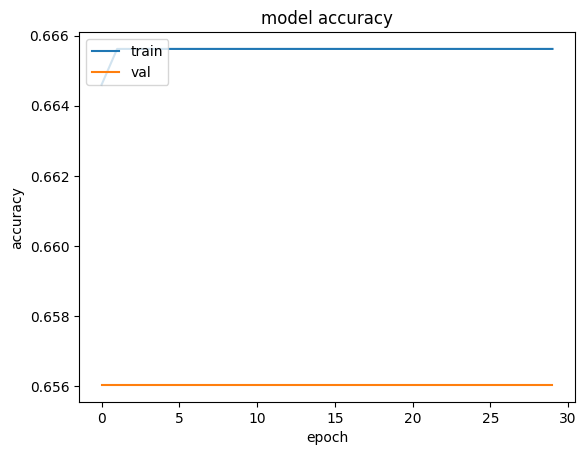

In [59]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
weights_c2 = np.zeros((len(word2id), 200))
emb2 = model_2.layers[2].get_weights()

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights_c2[i] = emb2[0][word2id[word]]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights_c2[i] = emb2[0][word2id['опрагпллирао']]

In [61]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False,
                                       weights=[weights_c2])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [62]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6303 - accuracy: 0.6656 - val_loss: 0.6167 - val_accuracy: 0.6560
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6178 - accuracy: 0.6656 - val_loss: 0.6161 - val_accuracy: 0.6560
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6172 - accuracy: 0.6656 - val_loss: 0.6157 - val_accuracy: 0.6560
Epoch 4/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6169 - accuracy: 0.6656 - val_loss: 0.6158 - val_accuracy: 0.6560
Epoch 5/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6163 - accuracy: 0.6656 - val_loss: 0.6153 - val_accuracy: 0.6560
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6161 - accuracy: 0.6656 - val_loss: 0.6149 - val_accuracy: 0.6560
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6157 - accuracy: 0.6656 - val_loss: 0.6145 - val_accuracy: 0.6560
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


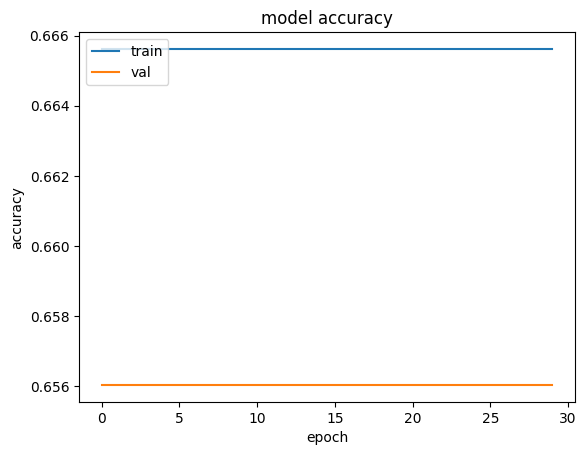

In [63]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
weights_c3 = np.zeros((len(word2id), 200))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights_c3[i] = w2v.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights_c3[i] = w2v.wv['опрагпллирао']

In [65]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200,
                                       trainable=False,
                                       weights=[weights_c3])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [66]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 3s 5ms/step - loss: 0.6461 - accuracy: 0.6604 - val_loss: 0.6215 - val_accuracy: 0.6560
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6195 - accuracy: 0.6658 - val_loss: 0.6133 - val_accuracy: 0.6560
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6155 - accuracy: 0.6658 - val_loss: 0.6111 - val_accuracy: 0.6560
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6132 - accuracy: 0.6658 - val_loss: 0.6097 - val_accuracy: 0.6560
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6116 - accuracy: 0.6659 - val_loss: 0.6083 - val_accuracy: 0.6574
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6101 - accuracy: 0.6661 - val_loss: 0.6070 - val_accuracy: 0.6574
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6089 - accuracy: 0.6665 - val_loss: 0.6058 - val_accuracy: 0.6588
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


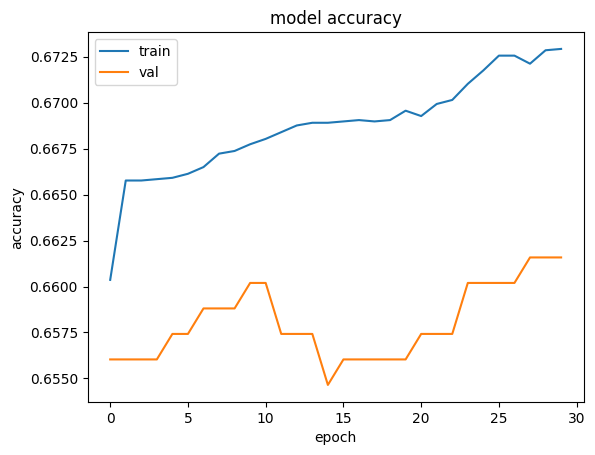

In [67]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
weights_c4 = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights_c4[i] = ft.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights_c4[i] = ft.wv['опрагпллирао']

In [70]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100,
                                       trainable=False,
                                       weights=[weights_c4])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [71]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 4s 7ms/step - loss: 0.6228 - accuracy: 0.6638 - val_loss: 0.6137 - val_accuracy: 0.6560
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6155 - accuracy: 0.6652 - val_loss: 0.6104 - val_accuracy: 0.6560
Epoch 3/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6126 - accuracy: 0.6653 - val_loss: 0.6085 - val_accuracy: 0.6560
Epoch 4/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6103 - accuracy: 0.6655 - val_loss: 0.6072 - val_accuracy: 0.6560
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6083 - accuracy: 0.6655 - val_loss: 0.6048 - val_accuracy: 0.6560
Epoch 6/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6065 - accuracy: 0.6656 - val_loss: 0.6035 - val_accuracy: 0.6574
Epoch 7/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6049 - accuracy: 0.6658 - val_loss: 0.6015 - val_accuracy: 0.6574
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


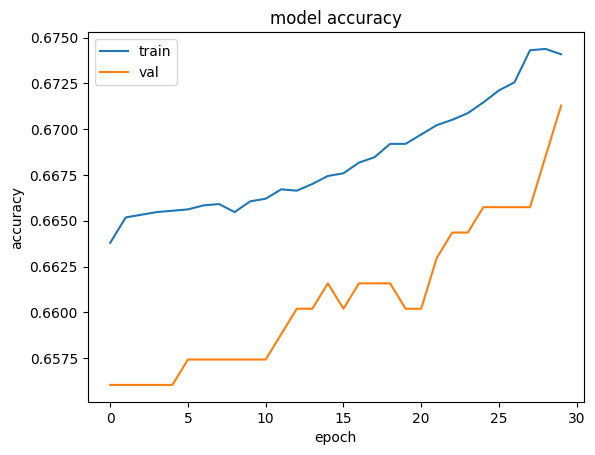

In [72]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Предобученная модель

In [79]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/ruscorpora_upos_skipgram_300_5_2018.vec', binary=False)

In [80]:
model['март_NOUN']

array([-1.65890e-02,  5.56540e-02,  1.41050e-02, -6.01020e-02,
        8.14130e-02, -4.29800e-03, -4.87910e-02, -5.22550e-02,
       -1.05372e-01, -1.54610e-02,  3.74430e-02, -3.05210e-02,
       -8.86700e-02, -5.94600e-03,  5.46470e-02,  2.02600e-02,
        4.62430e-02, -4.07070e-02, -5.21570e-02,  9.32900e-03,
        6.64200e-02, -4.30050e-02,  3.49920e-02,  1.21077e-01,
        2.30520e-02, -8.02720e-02,  3.05890e-02, -2.48240e-02,
       -1.01329e-01, -1.26552e-01,  2.65700e-02, -1.07510e-02,
       -6.23800e-03,  6.27250e-02, -1.48230e-02,  8.74340e-02,
        2.28800e-03, -1.19044e-01,  5.10420e-02,  5.38080e-02,
       -2.52240e-02, -2.30730e-02, -4.11970e-02,  4.77010e-02,
       -4.93050e-02, -9.83970e-02, -5.80080e-02, -1.85220e-02,
        4.50010e-02, -8.37630e-02,  7.91360e-02,  1.03360e-01,
        4.84000e-04,  3.30400e-03, -4.81080e-02, -1.20310e-02,
        6.77090e-02,  1.58310e-01, -1.54540e-02,  2.51830e-02,
       -1.82000e-04,  3.56800e-02, -5.55970e-02, -1.467

In [81]:
model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9469264149665833),
 ('январь_NOUN', 0.9385507702827454),
 ('декабрь_NOUN', 0.9291070699691772),
 ('ноябрь_NOUN', 0.9287325739860535),
 ('апрель_NOUN', 0.9180451035499573),
 ('октябрь_NOUN', 0.9116759300231934),
 ('май_NOUN', 0.8881860375404358),
 ('сентябрь_NOUN', 0.884035050868988),
 ('июнь_NOUN', 0.8719688057899475),
 ('август_NOUN', 0.8699690699577332)]

In [83]:
mapping = {}

for line in open('/content/drive/MyDrive/ru-rnc.map'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [84]:
from pymystem3 import Mystem
m = Mystem()

In [85]:

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue

        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens


In [86]:
data['norm_text_2'] = data.comment.apply(normalize_mystem)

In [87]:
len(data)

14412

In [88]:
data

,comment,toxic,norm_text,norm_text_2
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд-то, за, что, дебил, бл]","[верблюд_NOUN, то_PART, за_ADP, что_PRON, деби..."
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м...","[хохол_NOUN, это_PART, отдушина_NOUN, затюканы..."
2,Собаке - собачья смерть\n,1.0,"[собака, собачий, смерть]","[собака_NOUN, собачий_ADJ, смерть_NOUN]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновить, дебил, это, тоже, не, оск...","[страница_NOUN, обновлять_VERB, дебил_NOUN, эт..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убедить, 6-страничный, пдф, в, тот, ч...","[ты_PRON, не_PART, убеждать_VERB, страничный_A..."
...,...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибежать, и, ныть, ...","[вонючий_ADJ, совковый_ADJ, скот_NOUN, прибега..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кто, любить, гоблин, тупорылый, что-ли, ил...","[а_SCONJ, кто_PRON, любить_VERB, гоблин_NOUN, ..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотреть, утомлённый, солнце, 2, и, оказать...","[посмотреть_VERB, утомленный_ADJ, солнце_NOUN,..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушать, правило, раздел, т.к, в,...","[крымотред_ADV, нарушать_VERB, правило_NOUN, р..."


In [ ]:
data['norm_text_2']

In [89]:
vocab1 = Counter()

for text in data['norm_text_2']:
    vocab1.update(text)

filtered_vocab1 = set()

for word in vocab:
    if vocab1[word] > 5:
        filtered_vocab1.add(word)

len(filtered_vocab1)

0

In [90]:
word2id1 = { 'PAD':0}

for word in filtered_vocab1:
    word2id1[word] = len(word2id1)
id2word1 = {i:word for word, i in word2id1.items()}

In [91]:
X = []

for tokens in data['norm_text_2']:
    ids = [word2id1[token] for token in tokens if token in word2id1]
    X.append(ids)

In [92]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [93]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [94]:
weights_c5 = np.zeros((len(word2id1), 200))

for word, i in word2id1.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights_c5[i] = model.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights_c5[i] = model.wv['опрагпллирао']

In [95]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id1), output_dim=200,
                                       trainable=False,
                                       weights=[weights_c5])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [96]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6695 - accuracy: 0.6653 - val_loss: 0.6535 - val_accuracy: 0.6630
Epoch 2/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6454 - accuracy: 0.6653 - val_loss: 0.6419 - val_accuracy: 0.6630
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6390 - accuracy: 0.6653 - val_loss: 0.6394 - val_accuracy: 0.6630
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6378 - accuracy: 0.6653 - val_loss: 0.6391 - val_accuracy: 0.6630
Epoch 5/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6376 - accuracy: 0.6653 - val_loss: 0.6390 - val_accuracy: 0.6630
Epoch 6/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6375 - accuracy: 0.6653 - val_loss: 0.6391 - val_accuracy: 0.6630
Epoch 7/30
428/428 [==============================] - 2s 4ms/step - loss: 0.6375 - accuracy: 0.6653 - val_loss: 0.6391 - val_accuracy: 0.6630
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


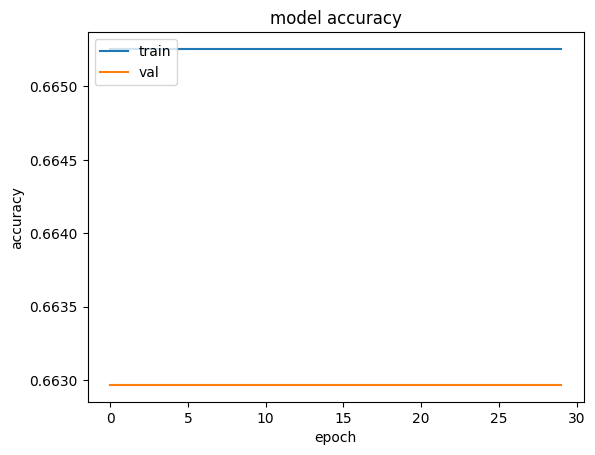

In [97]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Лучше других показала себя w2v модель